In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
import os.path
import pandas as pd
import numpy as np
import matplotlib as mpl
import gc_colors
plt.rcParams["figure.figsize"] = 15, 12

# Function definitions

In [2]:
def get_medians(data, n_parts=4):
    """Helper function for median uniformity."""
    datablocks = np.split(np.asarray(data), n_parts)
    medians = []
    for block in datablocks:
        medians.append(np.median(block))
        
    return medians

def median_uniformity(data, n_parts=4):
    """Split data in n_parts, calc median for each split and return the ratio of the min(medians)/max(medians).
    A larger value translates to a better uniformity!"""
    medians = np.asarray(get_medians(data, n_parts))
    
    #Remove one outlier
    #median_of_medians = np.median(medians)
    #abs_distance = np.abs(medians - median_of_medians)
    #medians = medians[np.arange(len(medians))!=np.argmax(abs_distance)]
    
    return min(medians)/max(medians)


def get_means(data, n_parts=4):
    """Helper function for median uniformity."""
    datablocks = np.split(np.asarray(data), n_parts)
    means = []
    for block in datablocks:
        means.append(np.mean(block))
        
    return means

def mean_uniformity(data, n_parts=4):
    """Split data in n_parts, calc median for each split and return the ratio of the min(medians)/max(medians).
    A larger value translates to a better uniformity!"""
    means = np.asarray(get_means(data, n_parts))
    
    #Remove one outlier
    #median_of_medians = np.median(medians)
    #abs_distance = np.abs(medians - median_of_medians)
    #medians = medians[np.arange(len(medians))!=np.argmax(abs_distance)]
    
    return min(means)/max(means)


def dynamic_median_uniformity(data, n_channels=100):
    """The idea is similar to median_uniformity but not with fixed channel positions. Instead it is looped over blocks
    of n_channels finding the block with the lowest and the largest median, and then calculating the ratio."""
    min_median, max_median = None, None
    if len(data) < n_channels:
        raise ValueError("n_channels is larger than len(data)")
    for i in range(len(data)-n_channels+1):
        median = np.median(data[i:i+n_channels])
        if median < min_median or min_median is None:
            min_median = median
        if median > max_median or max_median is None:
            max_median = median
            
    return min_median/max_median

def mean_absolute_deviation(data):
    return 1./len(data) * np.sum( np.abs( data - np.mean(data) ) )


#Load files========================================================================================================
def arduino2pandas(path):
    not_in_production = os.path.join(path, "HD*.csv")
    in_production = os.path.join(path, "In_Production/HD*.csv")
    destroyed = os.path.join(path, "Destroyed/HD*.csv")
    arduino_files = glob.glob(not_in_production)  #Bars on my desk
    arduino_files_production = glob.glob(in_production)  #Bars in production
    arduino_files_destroyed = glob.glob(destroyed) #Bars destroyed
    print("Found {0} ({1}) ({4}) arduino data files in '{2}/' ('{3}/') ('{5}/')"
          .format(len(arduino_files), len(arduino_files_production),os.path.dirname(not_in_production), 
                  os.path.dirname(in_production), len(arduino_files_destroyed), os.path.dirname(destroyed)))
    lightbar_dict = {}    #Dict containing the data (as pandas DataFrame) with lightbar name as key (e.g. "HD70")
    for category, files in enumerate([arduino_files, arduino_files_production, arduino_files_destroyed]):
        for filename in files:
            lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
            lightbar_nr = int(lightbar[2:])
            arduino_data = pd.read_csv(filename, delim_whitespace=True, comment='#', names=["Ch", "Blue", "Red"])
            if (arduino_data["Red"] < 0).all():
                data = arduino_data["Blue"].values
            else:
                data = arduino_data["Red"].values
            in_production = 0
            destroyed = 0
            if category == 1: in_production = 1
            elif category == 2: destroyed = 1
                
            lightbar_dict[lightbar_nr] = { "Has_Arduino" : 1, "Arduino_Data_VEC" : data, 
                                           "Arduino_In_Production" : in_production, "Arduino_Destroyed" : destroyed }
            
    #Convert to pandas DataFrame
    df = pd.DataFrame(lightbar_dict).transpose()
    df["Lightbar"] = df.index
    
    return df



def mattest2pandas(path):
    not_in_production = os.path.join(path, "HD*.csv")
    in_production = os.path.join(path, "In_Production/HD*.csv")
    mattest_files = glob.glob(not_in_production)  #Bars on my desk
    mattest_files_production = glob.glob(in_production)  #Bars in production
    destroyed = os.path.join(path, "Destroyed/HD*.csv")
    mattest_files_destroyed = glob.glob(destroyed) #Bars destroyed
    print("Found {0} ({1}) ({4}) mattest data files in '{2}/' ('{3}/') ('{5}/')"
          .format(len(mattest_files), len(mattest_files_production),os.path.dirname(not_in_production), 
                  os.path.dirname(in_production), len(mattest_files_destroyed), os.path.dirname(destroyed)))
    
    #Read uniformity file if available
    uniformity_file = glob.glob(os.path.join(path, "Uniformity.txt"))
    if uniformity_file:
        uniformity_file = uniformity_file[0]
        print("Found uniformity file: {0}".format(uniformity_file))

    uniformity_df = pd.read_csv("Lightuniformity_Meas/Mattest/Uniformity.txt", names=["Lightbar", "Uniformity"], 
                           delim_whitespace=True, comment="#")
    uniformity_df.index = np.asarray(uniformity_df["Lightbar"])

    lightbar_dict = {}    #Dict containing the data (as pandas DataFrame) with lightbar name as key (e.g. "HD70")
    for category, files in enumerate([mattest_files, mattest_files_production, mattest_files_destroyed]):
        for filename in files:
            lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
            lightbar_nr = int(lightbar[2:-5])
            led_brightness = int(lightbar[-2:])
            has_uniformity = int(lightbar_nr in uniformity_df["Lightbar"])
            if has_uniformity:
                uniformity = uniformity_df.loc[lightbar_nr]["Uniformity"]
            else:
                uniformity = "NA"
            mattest_data = pd.read_csv(filename, sep=";", skiprows=15, names=["Ch", "Pedestal", "Gain", "Mean_pixels"])
            in_production = 0
            destroyed = 0
            if category == 1: in_production = 1
            elif category == 2 : destroyed = 1
            
            
            lightbar_dict[lightbar_nr] = { "Has_Mattest" : 1,
                                           "Mattest_Data_VEC" : mattest_data["Mean_pixels"].values,
                                           "Mattest_Gain_VEC" : mattest_data["Gain"].values,
                                           "Mattest_Pedestal_VEC" : mattest_data["Pedestal"].values,
                                           "Mattest_Brightness" : led_brightness,
                                           "Mattest_In_Production" : in_production,
                                           "Mattest_Destroyed" : destroyed,
                                           "Mattest_Has_Uniformity" : has_uniformity,
                                           "Mattest_Uniformity" : uniformity }
            
    #Convert to pandas DataFrame
    df = pd.DataFrame(lightbar_dict).transpose()
    df["Lightbar"] = df.index
    
    return df



#Merge DataFrames =====================================================================================================
def merge_arduino_mattest(arduino_df, mattest_df):
    merged_df = pd.concat([arduino_df.drop("Lightbar", 1), mattest_df.drop("Lightbar", 1)], 1)
    merged_df["Lightbar"] = merged_df.index
    for has in ["Has_Arduino", "Has_Mattest", "Mattest_Has_Uniformity"]:
        merged_df[has] = merged_df[has].fillna(0)
    
    #Check for In_Production consistency and create new (common) column
    merged_df["In_Production"] = -1
    for bar, ard_prod, mat_prod, ard_destr, mat_destr in merged_df[ ["Lightbar", "Arduino_In_Production", 
                                                                    "Mattest_In_Production", 
                                                                    "Arduino_Destroyed", "Mattest_Destroyed"] ].values:
        #Check in Production column
        if np.isnan(ard_prod) and np.isnan(mat_prod):
            raise ValueError("No 'In_Production' entry found for lightbar {0}".format(bar))
        elif (not np.isnan(ard_prod)) and (not np.isnan(mat_prod)):
            if ard_prod == mat_prod:
                merged_df.set_value(bar, 'In_Production', ard_prod)
            else:
                raise ValueError("Inconsistency in 'In_Production' data for lightbar {0}".format(bar))
        elif not np.isnan(mat_prod):
            merged_df.set_value(bar, 'In_Production', mat_prod)
        elif not np.isnan(ard_prod):            
            merged_df.set_value(bar, 'In_Production', ard_prod)
        else:
            raise ValueError("Something went wrong when writing 'In_Production' data for lightbar {0}".format(bar))
            
        #Check destroyed column  
        if np.isnan(ard_destr) and np.isnan(mat_destr):
            raise ValueError("No 'Destroyed' entry found for lightbar {0}".format(bar))
        elif (not np.isnan(ard_destr)) and (not np.isnan(mat_destr)):
            if ard_destr == mat_destr:
                merged_df.set_value(bar, 'Destroyed', ard_destr)
            else:
                raise ValueError("Inconsistency in 'Destroyed' data for lightbar {0}".format(bar))
        elif not np.isnan(mat_destr):
            merged_df.set_value(bar, 'Destroyed', mat_destr)
        elif not np.isnan(ard_destr):            
            merged_df.set_value(bar, 'Destroyed', ard_destr)
        else:
            raise ValueError("Something went wrong when writing 'Destroyed' data for lightbar {0}".format(bar))     
    
    return merged_df.drop(["Arduino_In_Production", "Mattest_In_Production", "Arduino_Destroyed", 
                           "Mattest_Destroyed"], 1)



#Data manipulation ====================================================================================================
def correct_matteststep(merged_df, averaging=10):
    n = averaging #Number of median values to take for calc. the steps
    idx_low = 256  #Where the step begins
    idx_high = 384 #Where the step ends
   
    df = merged_df.copy()
    #Create default values
    df["Mattest_Stepfactor_Low"] = -10.
    df["Mattest_Stepfactor_High"] = -10.
    df["Mattest_Stepfactor_Avg"] = -10.
    df["Mattest_Corrected_Data_VEC"] = -10.
    df["Mattest_Corrected_Data_VEC"] = df["Mattest_Corrected_Data_VEC"].astype(np.ndarray)
    for bar, has_mattest, mattest_data in merged_df[ ["Lightbar", "Has_Mattest", "Mattest_Data_VEC"] ].values:
        if has_mattest:
            data = np.array(mattest_data)
            stepfactor_low = np.median(data[idx_low-n:idx_low])/np.median(data[idx_low:idx_low+10])
            stepfactor_high = np.median(data[idx_high:idx_high+n])/np.median(data[idx_high-n:idx_high])
            stepfactor = (stepfactor_low+stepfactor_high)/2
            data[idx_low:idx_high] = data[idx_low:idx_high] * stepfactor
                        
            df.set_value(bar, 'Mattest_Stepfactor_Low', stepfactor_low)
            df.set_value(bar, 'Mattest_Stepfactor_High', stepfactor_high)
            df.set_value(bar, 'Mattest_Stepfactor_Avg', stepfactor)
            df.set_value(bar, 'Mattest_Corrected_Data_VEC', data)

    return df


def add_characteristic(df, columns, func=np.mean, ending="Mean", n_remove_channels=32, *args, **kwargs):
    """columns is a list of columns (as string) for which the function should be evaluated (if availabel).
    The columns must have an VEC at the end of the name! args and kwargs will be forwarded to fun.
    n_remove_channels refers to the number of channels removed from both edges (necessary for the arduino data
    due to active area coverd by the plastic housing)"""
    if isinstance(columns,str):
        columns = [columns]
    
    output_df = df.copy()

    for column in columns:
        always = True
        has_str = "Lightbar"  #In case there is no Has check
        if "Mattest" in column:
            always = False
            has_str = "Has_Mattest"
            n_remove_channels = 0   #Don't remove channels for the mattest data!
        elif "Arduino" in column:
            always = False
            has_str = "Has_Arduino"
    
        if column[-3:] != "VEC":
            raise ValueError("Column name must end with 'VEC'!")
        
        output_column = column.replace("VEC", ending)
        print("Creating column {}".format(output_column))
        output_df[output_column] = -10.
        
        for bar, has, data in output_df[ ["Lightbar", has_str, column] ].values:
            if always or has:
                if n_remove_channels > 0:
                    data = data[n_remove_channels:-n_remove_channels]
                output_df.set_value(bar, output_column, func(data, *args, **kwargs))
        
    return output_df


#Plotting ============================================================================================================
def plot_2D(df, xcolumn_name, ycolumn_name, markersize=20, fontsize=14, legend="upper left"):
    uniformity_colors = {"bad" : "gcred", "ok" : "gcorange", "good" : "gcgreen", "None" : "gcblue"}


    #Plot in different colors
    for key, value in uniformity_colors.iteritems():
        if key == "None":
            datapart = df.loc[ df["Mattest_Has_Uniformity"] == 0]
        else: 
            datapart = df.loc[ df["Mattest_Uniformity"] == key ]
        if len(datapart) > 0:
            plt.plot( datapart[xcolumn_name], datapart[ycolumn_name], 
                      color=value, marker="o", lw=0, mew=0, ms=markersize, label=key)[0]

    #Plot numbers
    for x,y, lightbar_nr in df[ [xcolumn_name, ycolumn_name, "Lightbar"] ].values:
        plt.text(x,y, int(lightbar_nr), ha="center", va="center", color="w", weight="heavy", fontsize=fontsize)

    plt.legend(loc=legend)
    plt.minorticks_on()
    plt.grid()

    plt.xlabel(xcolumn_name)
    plt.ylabel(ycolumn_name)

# Load the necessary files and containing data

In [3]:
#arduino_df = arduino2pandas("Lightuniformity_Meas/LED5_INT50/")   #Normal measurement
#arduino_df = arduino2pandas("Lightuniformity_Meas/Rough_Plasticbar/")   #Rough plasticbar in-between
arduino_df = arduino2pandas("Lightuniformity_Meas/Airgap/")   #Airgap in-between
mattest_df = mattest2pandas("Lightuniformity_Meas/Mattest/")

merged_df = merge_arduino_mattest(arduino_df, mattest_df)

#Correct the step in the mattest data
corrected_df = correct_matteststep(merged_df)

#Add characteristics for the data
mean_df = add_characteristic(corrected_df, ["Arduino_Data_VEC", "Mattest_Corrected_Data_VEC"], np.mean, "Mean", 
                            n_remove_channels=32) #Mean
rel_std_df = add_characteristic(mean_df, ["Arduino_Data_VEC", "Mattest_Corrected_Data_VEC"], 
                                lambda x: np.std(x)/np.mean(x), "Rel_Std")
mad_df = add_characteristic(rel_std_df, ["Arduino_Data_VEC", "Mattest_Corrected_Data_VEC"], 
                                mean_absolute_deviation, "MAD")
uniformity_df = add_characteristic(mad_df, ["Arduino_Data_VEC", "Mattest_Corrected_Data_VEC"], median_uniformity,
                                   "Medianuniformity", n_parts = 4)
n_channels = 100   #Arduino channels
dynamic_uniformity_df = add_characteristic(uniformity_df, ["Arduino_Data_VEC"], dynamic_median_uniformity, 
                                           "Dynamic_Medianuniformity", n_channels=n_channels)
dynamic_uniformity_df = add_characteristic(dynamic_uniformity_df, ["Mattest_Corrected_Data_VEC"], dynamic_median_uniformity, 
                                           "Dynamic_Medianuniformity", n_channels=int(n_channels*512./896.))

df = dynamic_uniformity_df

df

Found 45 (32) (0) arduino data files in 'Lightuniformity_Meas/Airgap/' ('Lightuniformity_Meas/Airgap/In_Production/') ('Lightuniformity_Meas/Airgap/Destroyed/')
Found 50 (75) (4) mattest data files in 'Lightuniformity_Meas/Mattest/' ('Lightuniformity_Meas/Mattest/In_Production/') ('Lightuniformity_Meas/Mattest/Destroyed/')
Found uniformity file: Lightuniformity_Meas/Mattest/Uniformity.txt
Creating column Arduino_Data_Mean
Creating column Mattest_Corrected_Data_Mean
Creating column Arduino_Data_Rel_Std
Creating column Mattest_Corrected_Data_Rel_Std
Creating column Arduino_Data_MAD
Creating column Mattest_Corrected_Data_MAD
Creating column Arduino_Data_Medianuniformity
Creating column Mattest_Corrected_Data_Medianuniformity
Creating column Arduino_Data_Dynamic_Medianuniformity
Creating column Mattest_Corrected_Data_Dynamic_Medianuniformity


,Arduino_Data_VEC,Has_Arduino,Has_Mattest,Mattest_Brightness,Mattest_Data_VEC,Mattest_Gain_VEC,Mattest_Has_Uniformity,Mattest_Pedestal_VEC,Mattest_Uniformity,Lightbar,...,Arduino_Data_Mean,Mattest_Corrected_Data_Mean,Arduino_Data_Rel_Std,Mattest_Corrected_Data_Rel_Std,Arduino_Data_MAD,Mattest_Corrected_Data_MAD,Arduino_Data_Medianuniformity,Mattest_Corrected_Data_Medianuniformity,Arduino_Data_Dynamic_Medianuniformity,Mattest_Corrected_Data_Dynamic_Medianuniformity
48,NaN,0,1,45,"[163.173, 168.329, 183.954, 185.378, 184.667, ...","[63.31, 54.22, 61.84, 58.02, 58.88, 57.9, 55.8...",1,"[532.62, 612.79, 535.38, 613.32, 540.76, 610.4...",good,48,...,-10.000000,224.362312,-10.000000,0.147476,-10.000000,29.561299,-10.000000,0.743213,-10.000000,0.679524
49,NaN,0,1,44,"[179.045, 182.376, 199.461, 202.769, 200.641, ...","[62.78, 54.68, 61.99, 57.89, 59.08, 58.05, 55....",1,"[532.16, 612.79, 534.7, 612.71, 540.38, 610.04...",good,49,...,-10.000000,211.443833,-10.000000,0.105307,-10.000000,19.201025,-10.000000,0.811353,-10.000000,0.736186
50,NaN,0,1,45,"[193.69, 198.241, 218.694, 218.037, 218.437, 2...","[62.96, 54.09, 61.12, 57.65, 58.64, 57.21, 55....",1,"[531.29, 612.44, 534.11, 612.42, 539.86, 609.7...",good,50,...,-10.000000,226.697474,-10.000000,0.256691,-10.000000,20.731427,-10.000000,0.852761,-10.000000,0.747784
51,NaN,0,1,44,"[172.548, 173.001, 192.923, 194.709, 193.561, ...","[63.5, 54.92, 61.28, 57.41, 58.03, 57.84, 55.2...",1,"[532.42, 612.31, 534.97, 612.77, 539.74, 610.4...",good,51,...,-10.000000,246.247584,-10.000000,0.283849,-10.000000,42.040933,-10.000000,0.693331,-10.000000,0.606084
52,NaN,0,1,44,"[211.068, 217.424, 235.866, 237.187, 239.269, ...","[63.05, 54.2, 61.29, 57.57, 58.45, 57.76, 55.8...",1,"[530.32, 610.78, 533.25, 612.42, 538.78, 608.3...",good,52,...,-10.000000,246.743700,-10.000000,0.112418,-10.000000,21.534056,-10.000000,0.814537,-10.000000,0.713889
53,"[0.2745098, 0.2745098, 0.2745098, 0.2745098, 0...",1,1,45,"[150.023, 149.451, 162.735, 163.064, 161.777, ...","[62.12, 54.0, 61.16, 56.8, 58.06, 57.52, 55.44...",1,"[533.52, 613.14, 536.21, 614.36, 541.07, 610.4...",bad,53,...,1.327842,401.250911,0.613988,0.464221,0.697410,162.096206,0.200000,0.325306,0.135762,0.286048
55,NaN,0,1,47,"[143.499, 144.9, 158.319, 158.885, 157.796, 16...","[62.18, 54.12, 60.86, 57.02, 58.04, 56.92, 55....",1,"[533.51, 613.73, 536.13, 614.89, 541.7, 610.49...",ok,55,...,-10.000000,281.859252,-10.000000,0.279807,-10.000000,71.677411,-10.000000,0.505300,-10.000000,0.449933
57,NaN,0,1,45,"[198.234, 205.516, 226.089, 227.576, 228.448, ...","[63.54, 54.54, 61.2, 57.64, 58.33, 57.96, 56.0...",1,"[530.99, 611.84, 533.5, 611.81, 539.34, 608.21...",good,57,...,-10.000000,230.402659,-10.000000,0.125046,-10.000000,22.610165,-10.000000,0.760669,-10.000000,0.639148
59,NaN,0,1,45,"[209.466, 209.305, 227.189, 234.491, 232.014, ...","[62.5, 54.8, 62.17, 57.09, 58.41, 57.0, 55.79,...",1,"[531.07, 611.38, 533.68, 612.1, 539.13, 609.08...",good,59,...,-10.000000,278.630792,-10.000000,0.276300,-10.000000,49.340373,-10.000000,0.662721,-10.000000,0.580663
62,NaN,0,1,46,"[185.674, 186.532, 205.76, 207.284, 208.52, 21...","[62.48, 54.57, 61.05, 57.71, 58.99, 58.05, 56....",1,"[531.76, 611.91, 534.84, 612.82, 539.31, 608.8...",good,62,...,-10.000000,241.222104,-10.000000,0.294198,-10.000000,41.202663,-10.000000,0.646923,-10.000000,0.574935


# Median uniformity control plot for single lightbars

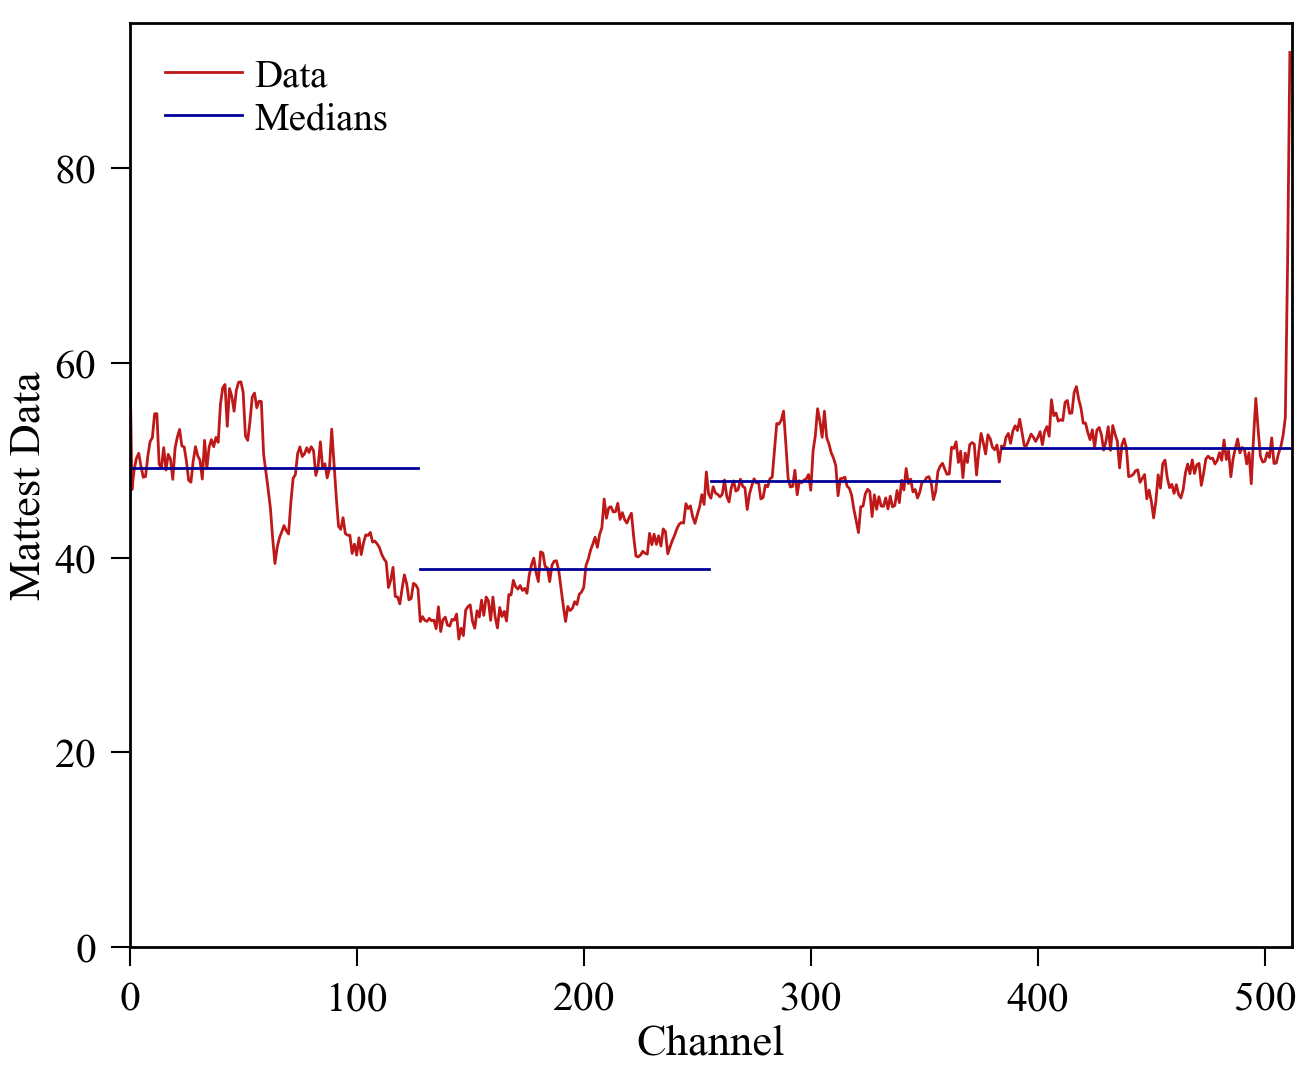

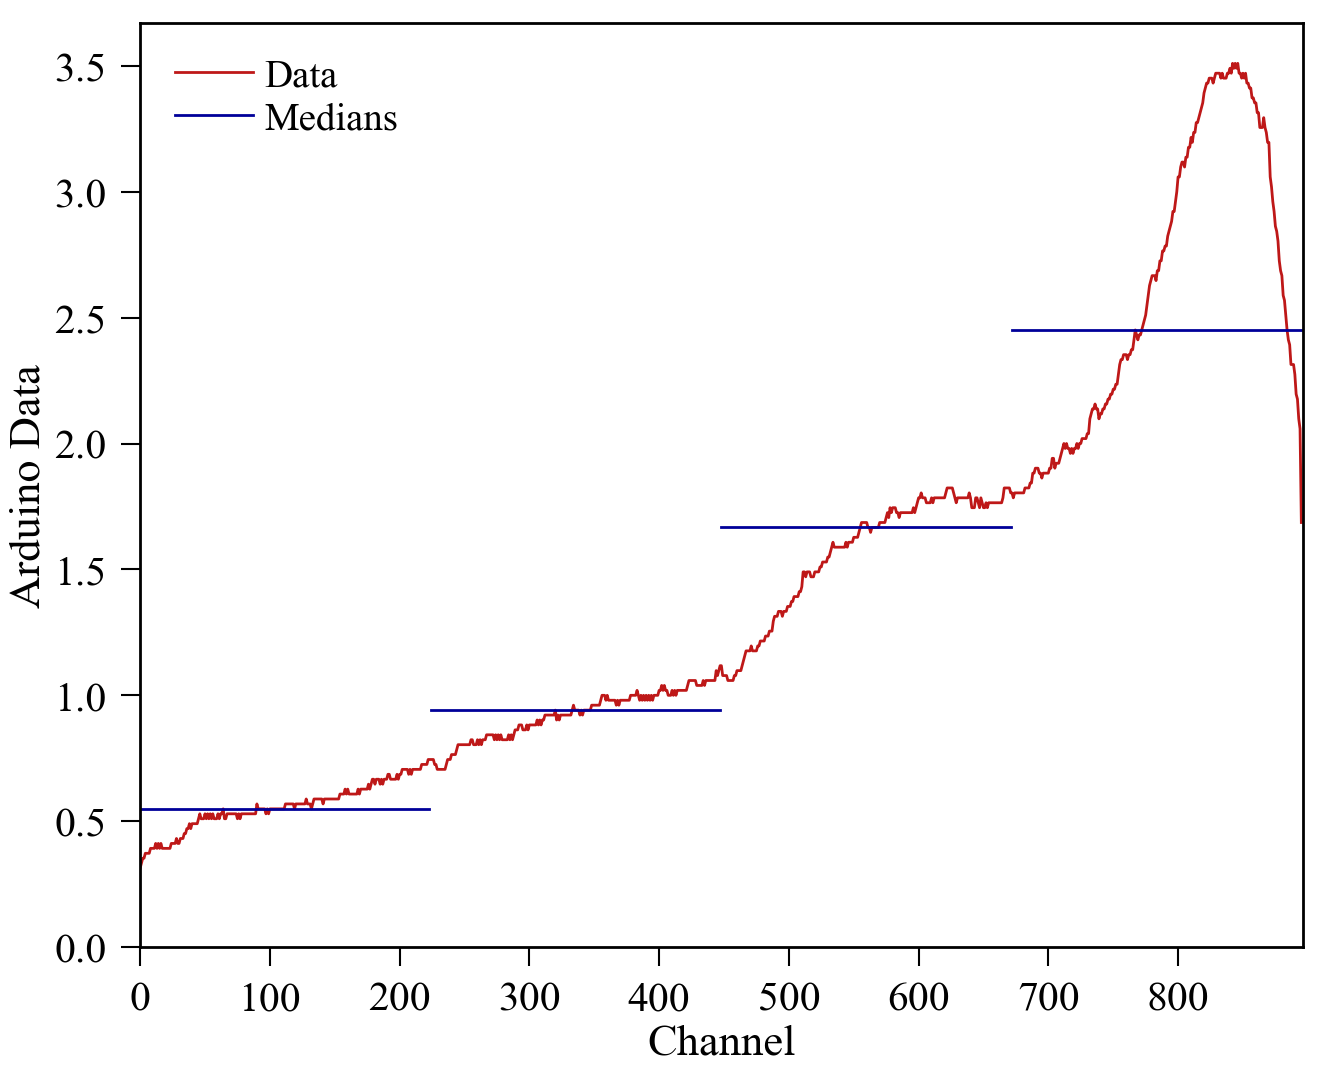

In [8]:
#Control plot
n_parts = 4
lightbar = 176
data_mattest = df.loc[lightbar]["Mattest_Corrected_Data_VEC"]
data_arduino = df.loc[lightbar]["Arduino_Data_VEC"]

for idx, data in enumerate([data_mattest, data_arduino]):
    medians = get_medians(data, n_parts)
    xticks = np.split(np.asarray(range(len(data))), n_parts)

    plt.plot(range(len(data)), data, "gcred", label="Data")
    for i in range(n_parts):
        if i == 0:
            plt.plot([xticks[i][0], xticks[i][-1]], [medians[i], medians[i]], "gcblue", label = "Medians")
        else:
            plt.plot([xticks[i][0], xticks[i][-1]], [medians[i], medians[i]], "gcblue")
    plt.xlabel("Channel")  
    plt.xlim(0, len(data))
    plt.ylim(0, plt.ylim()[1])
    if idx == 0:
        plt.ylabel("Mattest Data")
    elif idx == 1:
        plt.ylabel("Arduino Data")
    plt.legend(loc = "upper left")
    plt.show()
    plt.close()

## Plot dynamic median uniformity as control

100


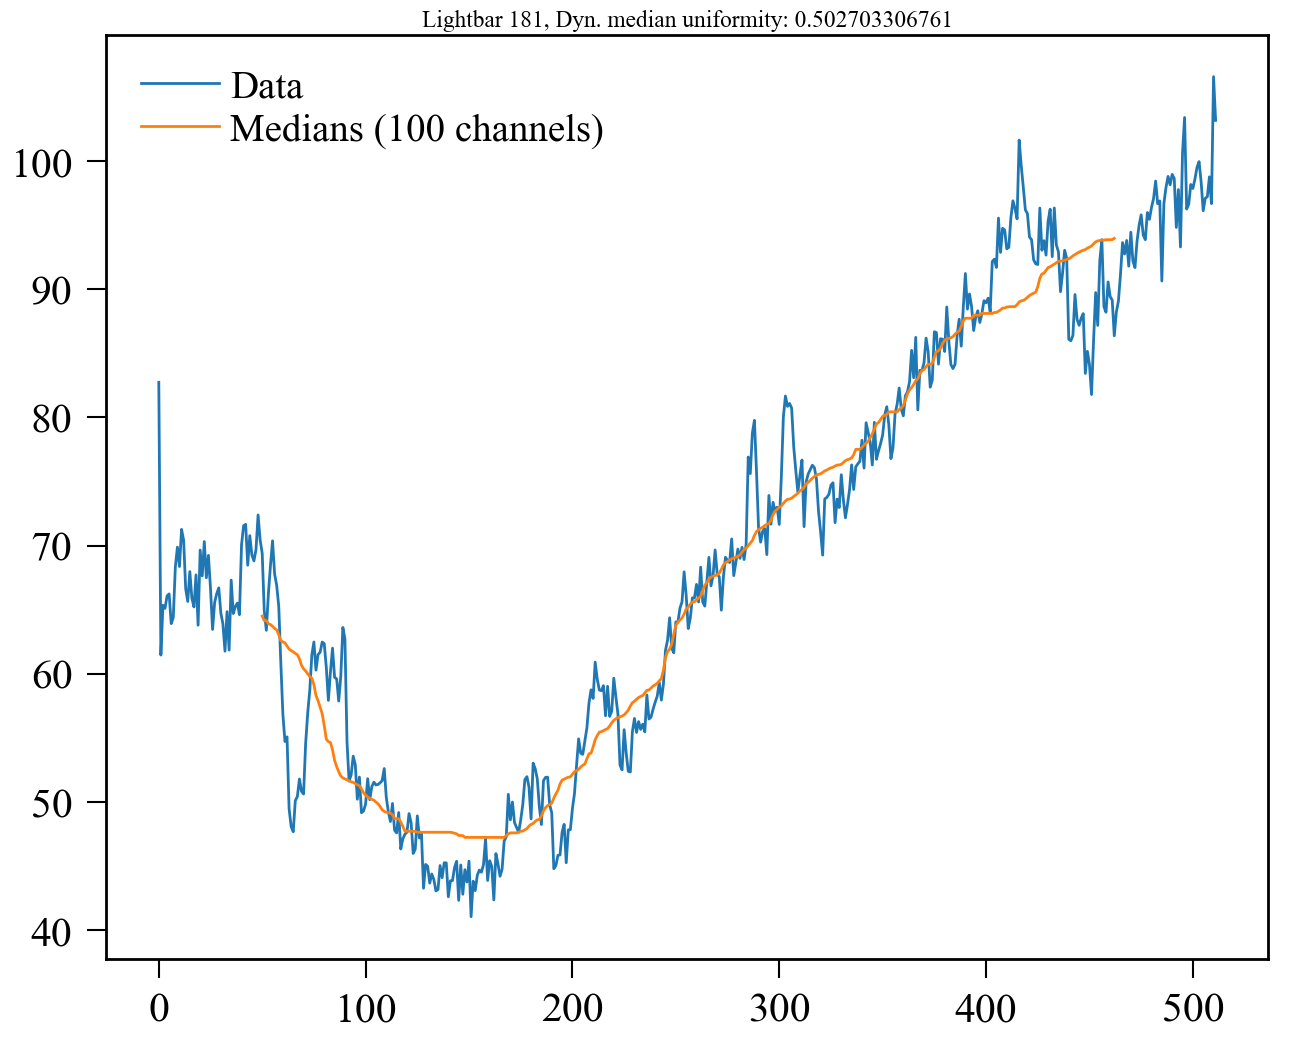

In [10]:
lightbar = 181
n_channels = 100  #Use `n_channels` for calculating the median

data = df.loc[lightbar]["Mattest_Corrected_Data_VEC"]
medians = [ np.median(data[i:i+n_channels]) for i in range(len(data)-n_channels+1) ]
plt.title("Lightbar {}, Dyn. median uniformity: {}".format(lightbar, dynamic_median_uniformity(data)), )
plt.plot(range(len(data)), data, label="Data")
plt.plot(np.asarray(range(len(medians)))+n_channels/2, medians, label="Medians ({} channels)".format(n_channels))
plt.legend(loc="upper left")
print(len(data)-len(medians)+1)

## Information about single lightbar

In [4]:
lightbar = 159
df.loc[lightbar]

Arduino_Data_VEC                                   [0.2745098, 0.2745098, 0.29411765, 0.29411765,...
Has_Arduino                                                                                        1
Has_Mattest                                                                                        1
Mattest_Brightness                                                                                38
Mattest_Data_VEC                                   [37.594, 31.992, 36.418, 37.126, 36.783, 36.59...
Mattest_Gain_VEC                                   [61.5, 54.31, 60.61, 57.21, 57.87, 58.14, 54.8...
Mattest_Has_Uniformity                                                                             0
Mattest_Pedestal_VEC                               [538.07, 617.32, 541.04, 617.37, 546.17, 614.6...
Mattest_Uniformity                                                                                NA
Lightbar                                                                                   

# 2D plot

129


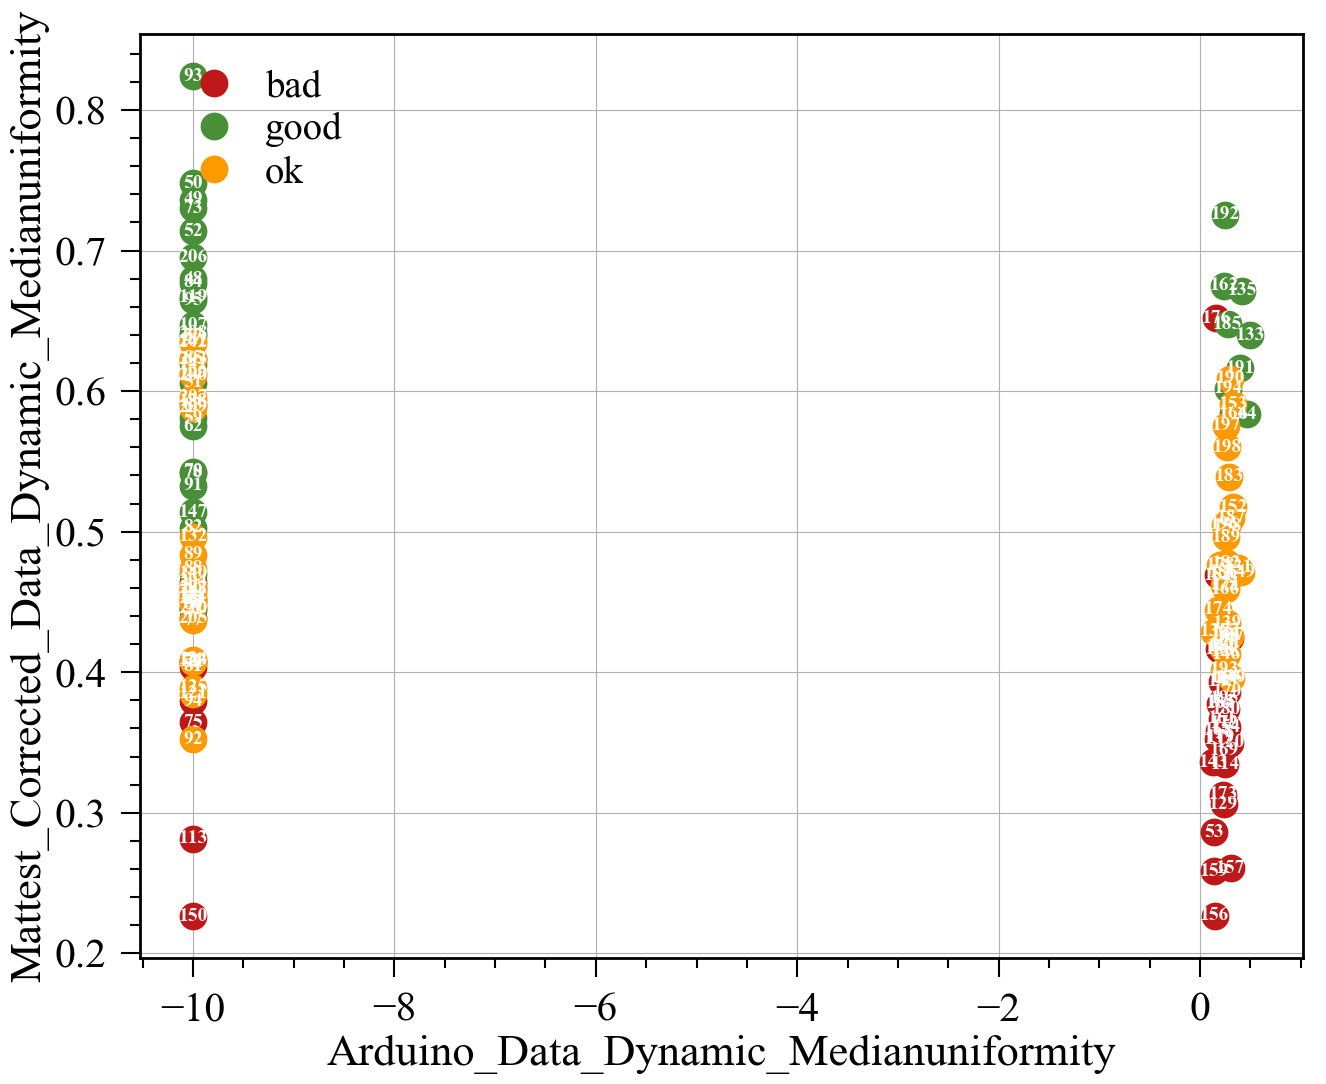

In [12]:
plot_df = df.query("Has_Mattest == 1")
print(len(plot_df))

plot_2D(plot_df, "Arduino_Data_Dynamic_Medianuniformity", "Mattest_Corrected_Data_Dynamic_Medianuniformity", legend="upper left")
#plt.plot([0,1], [0,1], "k--")
#plt.axhline(0.5, color="gcgreen")
#plt.axhline(0.4, color="gcorange")
#plt.axvline(0.4, color="gcgreen")
#plt.axvline(0.36, color="gcorange")


# Active area of the diode array?

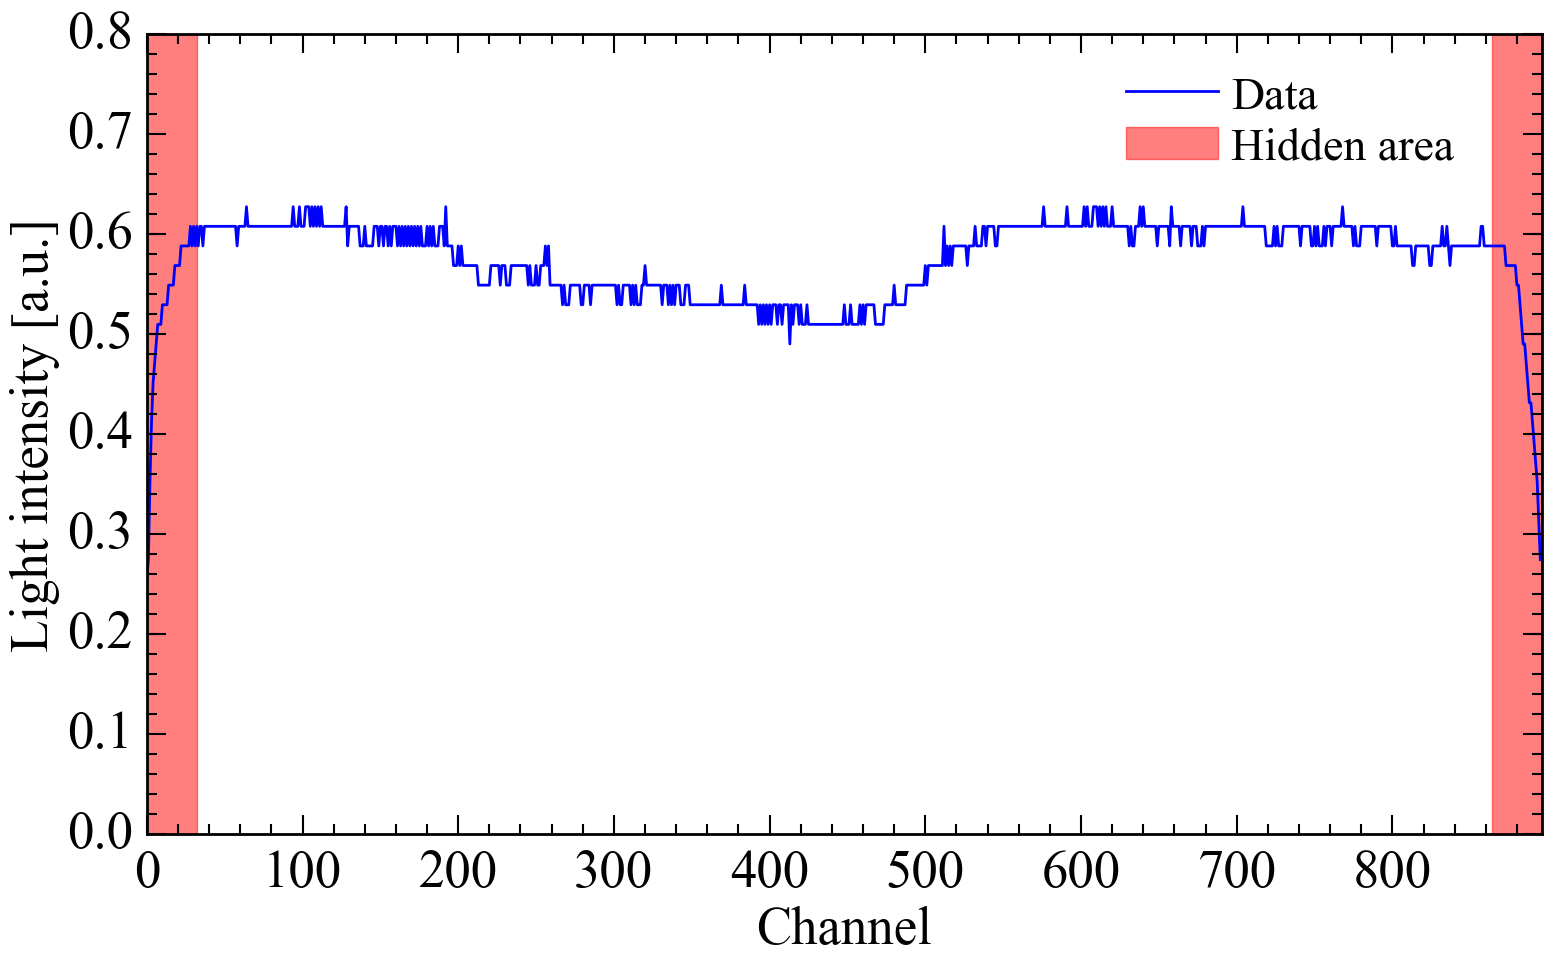

In [27]:
open_data = pd.read_csv("Open_Housing.csv", delim_whitespace=True, comment='#', names=["Ch", "Blue", "Red"])
mpl.rcParams["figure.figsize"] = 18, 10
plt.plot(open_data["Blue"], label="Data")
plt.xlim(0, len(open_data))
plt.ylim(0, 0.8)
plt.xlabel("Channel")
plt.ylabel("Light intensity [a.u.]")
plt.axvspan(0, 32, color="r", alpha=0.5, label="Hidden area    ")
plt.axvspan(len(open_data)-32, len(open_data), color="r", alpha=0.5)
plt.legend()
plt.minorticks_on()

## Edding Test

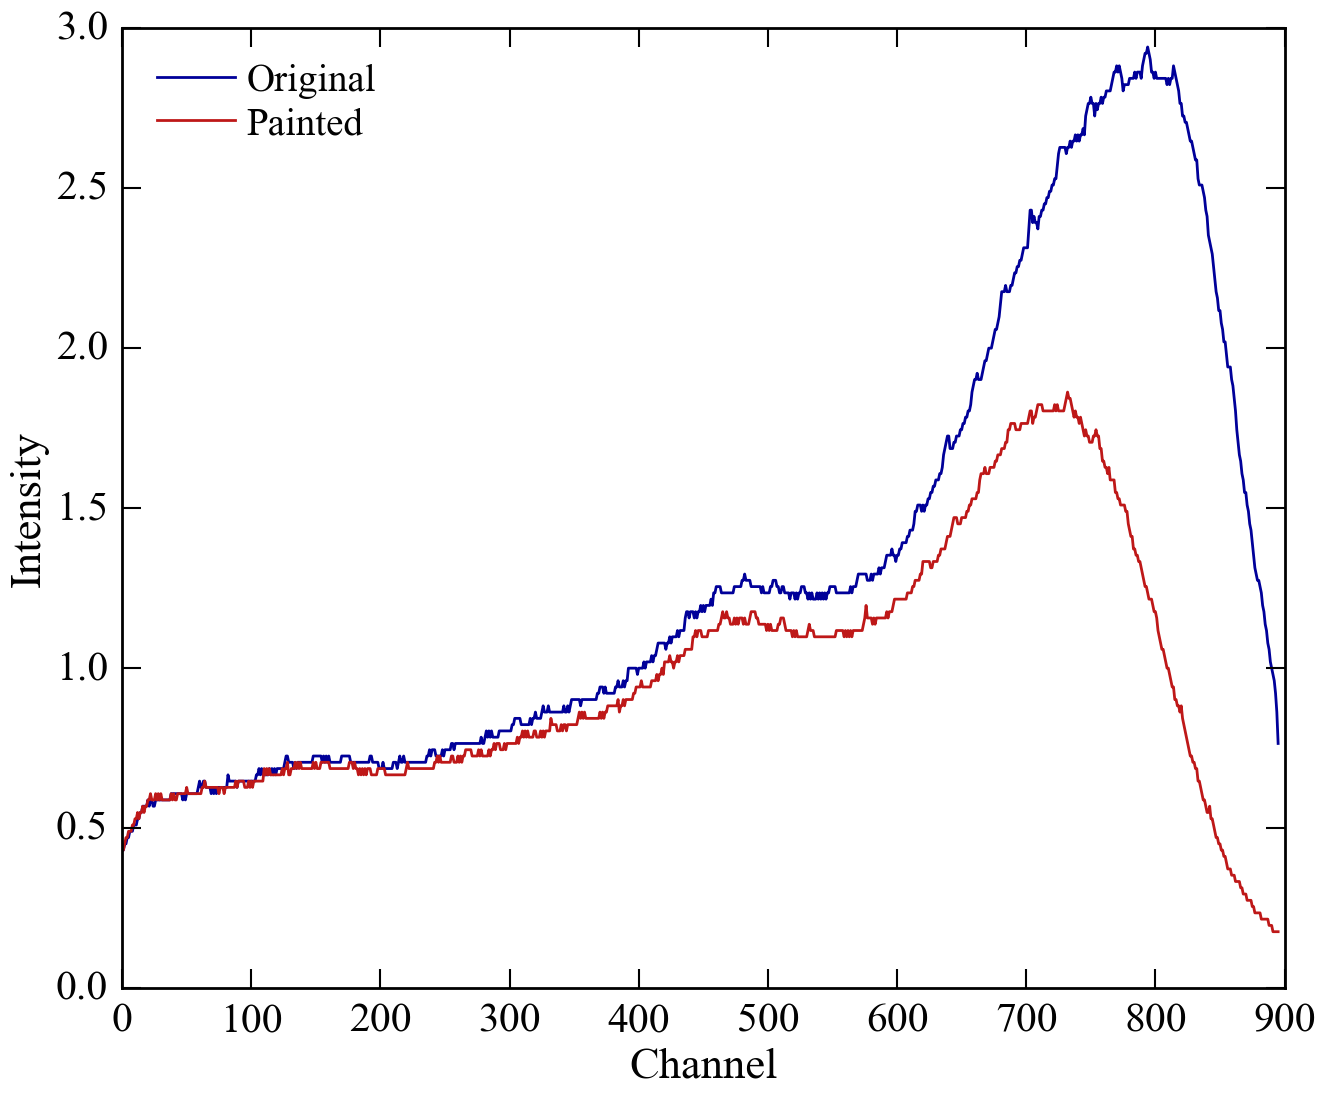

In [130]:
before = pd.read_csv("Edding_Test/HD113_Airgap_Before.csv", comment="#", delim_whitespace=True, names=["Ch", "Data", "NULL"])
after = pd.read_csv("Edding_Test/HD113_Airgap_Edding.csv", comment="#", delim_whitespace=True, names=["Ch", "Data", "NULL"])

plt.plot(before["Ch"], before["Data"], color="gcblue", label="Original")
plt.plot(after["Ch"], after["Data"], color="gcred", label="Painted")
plt.xlabel("Channel")
plt.ylabel("Intensity")
plt.legend(loc="upper left")

In [16]:
df.query('In_Production == 0 & Mattest_Has_Uniformity == 1 & Mattest_Uniformity != "bad" & Destroyed == 0')

,Arduino_Data_VEC,Has_Arduino,Has_Mattest,Mattest_Brightness,Mattest_Data_VEC,Mattest_Gain_VEC,Mattest_Has_Uniformity,Mattest_Pedestal_VEC,Mattest_Uniformity,Lightbar,...,Arduino_Data_Mean,Mattest_Corrected_Data_Mean,Arduino_Data_Rel_Std,Mattest_Corrected_Data_Rel_Std,Arduino_Data_MAD,Mattest_Corrected_Data_MAD,Arduino_Data_Medianuniformity,Mattest_Corrected_Data_Medianuniformity,Arduino_Data_Dynamic_Medianuniformity,Mattest_Corrected_Data_Dynamic_Medianuniformity
64,"[0.35294118, 0.37254902, 0.39215686, 0.3921568...",1,1,43,"[150.975, 152.325, 166.932, 170.324, 168.354, ...","[62.47, 54.44, 62.07, 57.81, 58.82, 57.18, 55....",1,"[532.76, 613.28, 535.76, 613.5, 541.11, 610.71...",good,64,...,0.797299,230.848003,0.265698,0.307543,0.161958,43.705639,0.535714,0.629471,0.468750,0.583482
107,NaN,0,1,39,"[207.514, 172.696, 180.44, 178.127, 177.186, 1...","[64.51, 55.28, 63.02, 58.59, 60.11, 58.68, 56....",1,"[532.6, 612.5, 535.91, 614.2, 540.16, 610.16, ...",good,107,...,-10.000000,250.219062,-10.000000,0.159811,-10.000000,35.954540,-10.000000,0.686627,-10.000000,0.646842
136,"[0.23529412, 0.21568627, 0.23529412, 0.2352941...",1,1,38,"[59.991, 59.024, 65.945, 67.518, 70.397, 70.10...","[63.17, 56.28, 63.17, 57.81, 58.75, 58.67, 56....",1,"[535.6, 616.34, 538.49, 616.55, 543.53, 613.69...",ok,136,...,0.901654,91.958882,0.564091,0.283341,0.396014,22.878064,0.160920,0.515816,0.141414,0.428769
139,"[0.43137255, 0.43137255, 0.45098039, 0.4509803...",1,1,38,"[58.657, 61.039, 68.291, 68.068, 70.377, 73.07...","[63.45, 55.14, 61.94, 58.83, 59.1, 57.83, 56.3...",1,"[536.18, 616.02, 538.86, 616.15, 544.06, 613.3...",ok,139,...,0.866587,91.713742,0.463566,0.269219,0.286127,21.344045,0.429752,0.523585,0.268817,0.434676
146,"[0.43137255, 0.45098039, 0.47058824, 0.4705882...",1,1,38,"[62.103, 63.724, 70.988, 71.813, 72.572, 75.69...","[62.81, 54.99, 62.38, 58.52, 59.22, 57.73, 56....",1,"[536.67, 616.06, 539.04, 616.32, 544.34, 613.6...",ok,146,...,1.285044,116.321493,0.481521,0.321282,0.566936,34.275277,0.342342,0.488178,0.265487,0.412790
